# Table of contents

1. [LSTM](#1.)
    1. [Feature Engineering](#1.1.)
        1. [Holidays Data Generation](#1.1.1.)
        2. [Cyclical feature encoding](#1.1.2.)
        3. [Feature Vector Normalization](#1.1.3.)
    2. [Modeling](#1.2.)
3. [Further Readings](#2.)

# LSTM <a class="anchor" id="1."></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display


from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')

In [2]:
ts = pd.read_csv("cleaned-daily.csv", parse_dates = ['Date'])
ts = ts.set_index('Date')[["kWh"]].sort_index().asfreq('d')
ts.head(15)

,kWh
Date,
2017-01-01,399131.94
2017-01-02,545259.57
2017-01-03,557400.78
2017-01-04,557394.31
2017-01-05,554266.71
2017-01-06,484772.87
2017-01-07,448601.37
2017-01-08,433151.95
2017-01-09,638036.96


<AxesSubplot:xlabel='Date'>

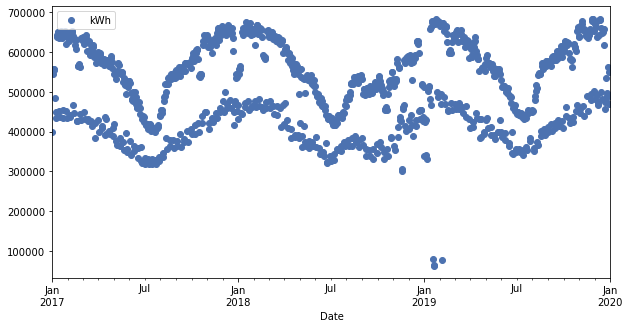

In [3]:
ts.plot(figsize=(10,5),style="o")

## Feature Engineering <a class="anchor" id="1.1."></a>

By preparing the data well in advance, we can help simplify models and improve their performance by a great extent with comparatively little effort. This means to come up with better representations of data or adding more useful information, i.e. to engineer features.

### Holidays Data Generation <a class="anchor" id="1.1.1."></a>

To get started, the exogenous 'holiday' variable can be reused entirely from the SARIMAX model.

In [4]:
import holidays

begin = '2017-01-01'
end = '2019-12-31' # errors within the holidays package
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts

,kWh,holidays
Date,,
2017-01-01,399131.94,1
2017-01-02,545259.57,0
2017-01-03,557400.78,0
2017-01-04,557394.31,0
2017-01-05,554266.71,0
...,...,...
2019-12-28,490973.42,0
2019-12-29,470181.83,0
2019-12-30,550293.99,0


### Cyclical feature encoding <a class="anchor" id="1.1.2."></a>

The separate datetime data on its own is not very useful to the learning task. Therefore, we need a way to encode the periodicity of the time series from our knowledge into the data. This can be achieved by modelling time as a circular scale, which is simply mapping the date time values using trigonometric functions.

In [5]:
date = ts.index
timestamp_s = date.map(datetime.datetime.timestamp)

In [6]:
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

Text(0.5, 1.0, 'Time of week signal')

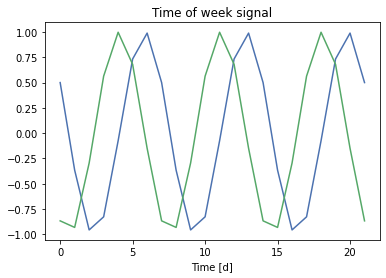

In [7]:
plt.plot(np.array(ts['Week sin'])[:22])
plt.plot(np.array(ts['Week cos'])[:22])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [8]:
ts.head(10)

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,399131.94,1,0.500000,-0.866025
2017-01-02,545259.57,0,-0.365341,-0.930874
2017-01-03,557400.78,0,-0.955573,-0.294755
2017-01-04,557394.31,0,-0.826239,0.563320
2017-01-05,554266.71,0,-0.074730,0.997204
2017-01-06,484772.87,1,0.733052,0.680173
2017-01-07,448601.37,0,0.988831,-0.149042
2017-01-08,433151.95,0,0.500000,-0.866025
2017-01-09,638036.96,0,-0.365341,-0.930874


In [9]:
ts.describe()

,kWh,holidays,Week sin,Week cos
count,1096.000000,1096.000000,1096.000000,1096.000000
mean,513641.385976,0.028285,-0.001503,-0.001394
std,101693.964087,0.165861,0.707415,0.707442
min,61980.910000,0.000000,-0.955573,-0.943883
25%,434430.260000,0.000000,-0.826239,-0.846724
50%,519402.665000,0.000000,-0.111964,-0.111964
75%,597521.062500,0.000000,0.707107,0.680173
max,683808.340000,1.000000,0.993712,0.997204


### Feature Vector Normalization <a class="anchor" id="1.1.3."></a>

Since there are big discrepancies between the scales of the different features, we need to normalize them into a common scale, without distorting the differences in the ranges of values or losing information.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts[["kWh"]])
ts_normalized = pd.DataFrame(scaler.fit_transform(ts),
                             columns = ts.columns.values,
                            index = ts.index)

In [11]:
ts_normalized

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.542194,1.0,7.467214e-01,0.040110
2017-01-02,0.777191,0.0,3.027940e-01,0.006702
2017-01-03,0.796716,0.0,7.915890e-14,0.334415
2017-01-04,0.796706,0.0,6.634947e-02,0.776474
2017-01-05,0.791676,0.0,4.518799e-01,1.000000
...,...,...,...,...
2019-12-28,0.689890,0.0,9.974958e-01,0.409482
2019-12-29,0.656454,0.0,7.467214e-01,0.040110
2019-12-30,0.785287,0.0,3.027940e-01,0.006702


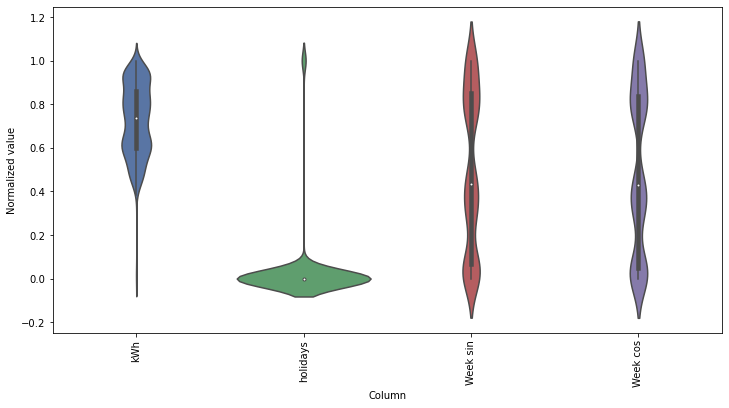

In [12]:
melt_plot = ts_normalized.melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(ts_normalized.keys(), rotation=90)

## Modeling <a class="anchor" id="1.2."></a>

Certainly, we need to split the dataset into train, validation, and test sets first. The test set here will be of the same time period as the one in the SARIMAX model, so we can compare the performance more easily.

In [13]:
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'

test_df = ts_normalized[train_end:]
train_val = ts_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.542194,1.0,7.467214e-01,4.011047e-02
2017-01-02,0.777191,0.0,3.027940e-01,6.702214e-03
2017-01-03,0.796716,0.0,7.915890e-14,3.344147e-01
2017-01-04,0.796706,0.0,6.634947e-02,7.764738e-01
2017-01-05,0.791676,0.0,4.518799e-01,1.000000e+00
...,...,...,...,...
2019-04-28,0.532413,0.0,7.631541e-01,5.005398e-02
2019-04-29,0.818335,0.0,3.207811e-01,2.004508e-13
2019-04-30,0.786616,0.0,5.996802e-03,3.161137e-01


In order for the LSTM to work, we need to create sliding windows from the data so that for each datapoint, its features is the window of a determined size of the past values . In this project, the width of the features vector is 28 days, or 4 weeks, while there is only one label for each window. 

![A window of data](data_window.png "A window of data")

In [14]:
import random

def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list): list of the columns for the labels.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
    print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
          .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [15]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_ts,y_ts = split_sequence(ts_normalized,randomize=False)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 4), (1,))

The only secondary step left is to convert the data into Pytorch Tensors.

In [16]:
def to_tensor(ls):
    return Variable(torch.cuda.FloatTensor(np.array(ls)))

X_ts,y_ts = to_tensor(X_ts),to_tensor(y_ts)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

tensor([[[5.4219e-01, 1.0000e+00, 7.4672e-01, 4.0110e-02],
         [7.7719e-01, 0.0000e+00, 3.0279e-01, 6.7022e-03],
         [7.9672e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         ...,
         [9.3904e-01, 0.0000e+00, 4.5188e-01, 1.0000e+00],
         [8.9637e-01, 0.0000e+00, 8.6628e-01, 8.3667e-01],
         [6.2653e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01]],

        [[7.7719e-01, 0.0000e+00, 3.0279e-01, 6.7022e-03],
         [7.9672e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         [7.9671e-01, 0.0000e+00, 6.6349e-02, 7.7647e-01],
         ...,
         [8.9637e-01, 0.0000e+00, 8.6628e-01, 8.3667e-01],
         [6.2653e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01],
         [6.0036e-01, 0.0000e+00, 7.4672e-01, 4.0110e-02]],

        [[7.9672e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         [7.9671e-01, 0.0000e+00, 6.6349e-02, 7.7647e-01],
         [7.9168e-01, 0.0000e+00, 4.5188e-01, 1.0000e+00],
         ...,
         [6.2653e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01],
         [

We now can finally get to building the neural network! Our model has 2 hidden LSTM layers with 512 neurons each. The input and output layers has 4 and 1 nodes, respectively, which corresponds to the shape of the features and labels vector. The Adam optimizer is used, and the learning rate is dynamically modified using a scheduler.

In [17]:
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn

In [18]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 350
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [19]:
for epoch in progress_bar(range(1,num_epochs+1)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    if epoch%20 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

Epoch: 1, loss: 0.66936 validation loss:  0.17561 
Epoch: 21, loss: 0.10947 validation loss:  0.08660 
Epoch: 41, loss: 0.10266 validation loss:  0.08062 
Epoch: 61, loss: 0.09978 validation loss:  0.07446 
Epoch: 81, loss: 0.09691 validation loss:  0.07439 
Epoch: 101, loss: 0.08863 validation loss:  0.06301 
Epoch: 121, loss: 0.08381 validation loss:  0.04544 
Epoch: 141, loss: 0.07602 validation loss:  0.03849 
Epoch: 161, loss: 0.07377 validation loss:  0.03512 
Epoch: 181, loss: 0.07201 validation loss:  0.03611 
Epoch: 201, loss: 0.07127 validation loss:  0.03537 
Epoch: 221, loss: 0.06585 validation loss:  0.03407 
Epoch: 241, loss: 0.06035 validation loss:  0.03204 
Epoch: 261, loss: 0.05059 validation loss:  0.04811 
Epoch: 281, loss: 0.04645 validation loss:  0.02620 
Epoch: 301, loss: 0.04903 validation loss:  0.03526 
Epoch: 321, loss: 0.04480 validation loss:  0.03639 
Epoch: 341, loss: 0.04446 validation loss:  0.02677 
Final: 
Epoch: 350, loss: 0.04426 validation loss:  

So far, so good. Now we need to check the error of the model on the test set without normalization. 

In [23]:
from sklearn.metrics import mean_squared_error

model.eval()

## Inverse Normalize 
y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)))

The root mean squared error of the model is 70543.07


This is only a marginal improvement over the SARIMAX model. In fact, we can see that the LSTM model performs worse than the classical method after accounting for the far greater level of complexity of the Deep Neural Networks. This is in agreement with the literature on time series forecasting, with deep learning methods having not delivered on their promises.

Nevertheless, we can further examine the fitness of the model on the data by visualizing the results, starting with the all the data available.

Text(0, 0.5, 'kWh')

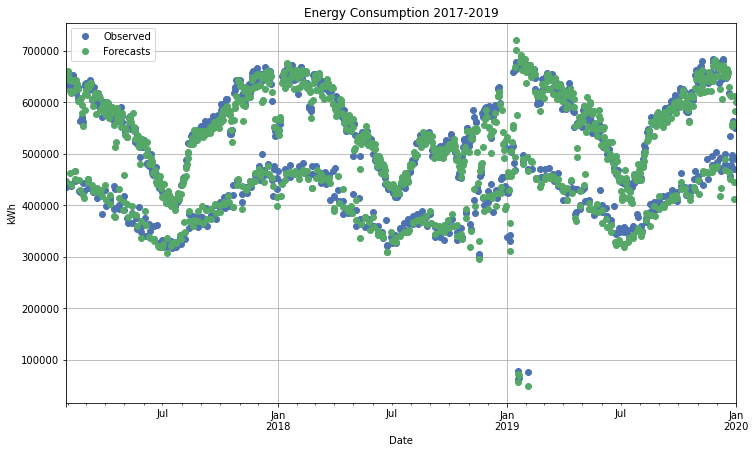

In [24]:
y_pred = scaler_kwh.inverse_transform(model(X_ts).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts.cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df,pred_df],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = 'o', grid=True)
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")

The forecasts appear to fit the observed values well, but is worse than that of the SARIMA with consistent under-prediction of the max values. Let us look at the prediction on the test set compare it with that of the SARIMAX.

Text(0, 0.5, 'kWh')

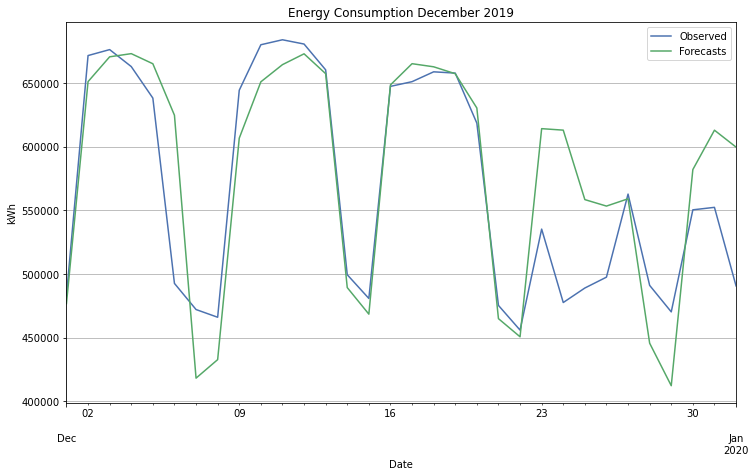

In [25]:
fig, ax = plt.subplots()
plot_df.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)

ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption December 2019")
ax.set_ylabel("kWh")

Despite better fitness during some time points, the model consistently under-predict the values by a wide margin. Concerning the holiday period, the forecasts still have the same defects as that of the SARIMAX model.

In conclusion, even though the presented models have presented reasonable accuracy, time series forecasting still presents many challenges. That said, this is still a very active research area, offering much improvement in the future.

# Further Readings <a class="anchor" id="2."></a>

* [Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition. *OTexts: Melbourne, Australia*](https://otexts.com/fpp2/)
* [Shumway, R., & Stoffer, D. (2017). Time Series Analysis and Its Applications. *Springer Texts In Statistics*. https://doi.org/10.1007/978-3-319-52452-8](https://www.springer.com/gp/book/9783319524511)
*[SARIMAX: Introduction. *Statsmodels.org. (2021)*. Retrieved 17 January 2021.](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html.)
* [NIST/SEMATECH e-Handbook of Statistical Methods. Retrieved 17 January 2021.](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc445.htm)
* [Time series forecasting: TensorFlow Core.](https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering)
* [Zhang, G. (2012). Neural Networks for Time-Series Forecasting. *Handbook of Natural Computing*, 461–477.](https://link.springer.com/referenceworkentry/10.1007%2F978-3-540-92910-9_14#citeas)